# **Cuantización de Modelos**

La cuantización de modelos es una técnica esencial en el campo del aprendizaje automático que permite reducir el tamaño y la complejidad de los modelos sin sacrificar significativamente su precisión. A continuación, exploraremos cómo implementarla.

# **Cómo Cuantizar Modelos**
La cuantización puede realizarse de varias maneras. Las técnicas más comunes incluyen la cuantización estática, la cuantización dinámica y la cuantización de entrenamiento con conciencia cuantizada.

- **Cuantización Estática:** En esta técnica, se analizan los datos de entrada y salida del modelo antes de la inferencia para determinar los rangos adecuados para la cuantización. Los pesos y las activaciones se cuantizan utilizando estos rangos predefinidos, lo que permite optimizaciones adicionales.

In [ ]:
import torch
import torch.quantization

# Crear un modelo sencillo
class ModeloSencillo(torch.nn.Module):
    def __init__(self):
        super(ModeloSencillo, self).__init__()
        self.fc = torch.nn.Linear(10, 2)

    def forward(self, x):
        return self.fc(x)

# Instanciar el modelo y prepararlo para cuantización
model = ModeloSencillo()
model.qconfig = torch.quantization.get_default_qconfig('fbgemm')
torch.quantization.prepare(model, inplace=True)

# Simular datos de calibración
datos_calibracion = torch.randn(100, 10)
model(datos_calibracion)

# Cuantizar el modelo
torch.quantization.convert(model, inplace=True)

# Mostrar el modelo cuantizado
print(model)

/usr/local/lib/python3.11/dist-packages/torch/ao/quantization/observer.py:229: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


ModeloSencillo(
  (fc): QuantizedLinear(in_features=10, out_features=2, scale=0.02537916973233223, zero_point=73, qscheme=torch.per_channel_affine)
)


- **Cuantización Dinámica:** Aquí, los pesos del modelo se cuantizan antes de la inferencia, pero las activaciones se cuantizan dinámicamente durante la inferencia. Esta técnica es útil para modelos que se ejecutan en dispositivos con capacidades de cómputo más limitadas. En otras palabras, convierte pesos a menor precisión durante la inferencia, manteniendo activaciones en FP32.

In [ ]:
import torch.quantization

# Cuantización dinámica del modelo
model_dynamic = torch.quantization.quantize_dynamic(model, {torch.nn.Linear}, dtype=torch.qint8)

# Mostrar el modelo cuantizado dinámicamente
print(model_dynamic)

ModeloSencillo(
  (fc): QuantizedLinear(in_features=10, out_features=2, scale=0.02537916973233223, zero_point=73, qscheme=torch.per_channel_affine)
)


- **Cuantización de Entrenamiento con Conciencia Cuantizada (QAT):** Esta técnica ajusta el modelo durante el entrenamiento para que sea robusto a la cuantización. Aunque es más compleja, puede resultar en modelos cuantizados con mejor desempeño. Ajusta pesos en menor precisión durante el entrenamiento para reducir la pérdida de precisión.

In [ ]:
!pip install torch

# Importamos las librerías necesarias
import torch
import torch.nn as nn
import torch.quantization
from torch.utils.data import TensorDataset, DataLoader

# Definimos el dispositivo (GPU si está disponible, CPU en caso contrario)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Crear un modelo sencillo
class ModeloSencillo(nn.Module):  # Modelo hereda de nn.Module
    def __init__(self):
        super(ModeloSencillo, self).__init__()
        self.fc = nn.Linear(10, 2)

    def forward(self, x):
        return self.fc(x)

# Instanciar el modelo y moverlo al dispositivo
model = ModeloSencillo().to(device)

# Preparar el modelo para QAT (Quantization Aware Training)
model.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')
torch.quantization.prepare_qat(model, inplace=True)

# Definir datos simulados de entrenamiento y moverlos al dispositivo
datos = torch.randn(100, 10).to(device)
etiquetas = torch.randint(0, 2, (100,)).to(device)
dataset = TensorDataset(datos, etiquetas)
dataloader = DataLoader(dataset, batch_size=10)

# Definir la función de pérdida
criterion = nn.CrossEntropyLoss()

# Definir el optimizador, pasandole los parámetros del modelo
optim = torch.optim.SGD(model.parameters(), lr=0.01)

# Entrenar el modelo
for epoch in range(10):
    for datos, etiquetas in dataloader:
        # Poner a cero los gradientes
        optim.zero_grad()
        # Hacer la predicción con el modelo
        salida = model(datos)
        # Calcular la pérdida
        perdida = criterion(salida, etiquetas)
        # Calcular los gradientes
        perdida.backward()
        # Actualizar los pesos del modelo
        optim.step()

# Convertir a modelo cuantizado
torch.quantization.convert(model, inplace=True)

# Mostrar el modelo cuantizado
print(model)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

/usr/local/lib/python3.11/dist-packages/torch/ao/quantization/observer.py:229: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


- **Cuantización de Post-Entrenamiento:** Convierte pesos y activaciones con calibración usando datos de entrada.

In [ ]:
# Installs pytorch
!pip install torch
# Importamos las librerías necesarias
import torch
import torch.nn as nn
import torch.quantization
from torch.utils.data import TensorDataset, DataLoader

# Definimos el dispositivo (GPU si está disponible, CPU en caso contrario)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Crear un modelo sencillo
class ModeloSencillo(nn.Module):  # Modelo hereda de nn.Module
    def __init__(self):
        super(ModeloSencillo, self).__init__()
        self.fc = nn.Linear(10, 2)

    def forward(self, x):
        return self.fc(x)

# Instanciar el modelo y moverlo al dispositivo
model = ModeloSencillo().to(device)

# Preparar el modelo para QAT (Quantization Aware Training)
model.qconfig = torch.quantization.get_default_qat_qconfig('fbgemm')
torch.quantization.prepare_qat(model, inplace=True)

# Definir datos simulados de entrenamiento y moverlos al dispositivo
datos = torch.randn(100, 10).to(device)
etiquetas = torch.randint(0, 2, (100,)).to(device)
dataset = TensorDataset(datos, etiquetas)
dataloader = DataLoader(dataset, batch_size=10)

# Definir la función de pérdida
criterion = nn.CrossEntropyLoss()

# Definir el optimizador, pasandole los parámetros del modelo
optim = torch.optim.SGD(model.parameters(), lr=0.01)

# Entrenar el modelo
for epoch in range(10):
    for datos, etiquetas in dataloader:
        # Poner a cero los gradientes
        optim.zero_grad()
        # Hacer la predicción con el modelo
        salida = model(datos)
        # Calcular la pérdida
        perdida = criterion(salida, etiquetas)
        # Calcular los gradientes
        perdida.backward()
        # Actualizar los pesos del modelo
        optim.step()

# Convertir a modelo cuantizado
torch.quantization.convert(model, inplace=True)

# Mostrar el modelo cuantizado
print(model)

/usr/local/lib/python3.11/dist-packages/torch/ao/quantization/observer.py:229: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


ModeloSencillo(
  (fc): QuantizedLinear(in_features=10, out_features=2, scale=0.0224764384329319, zero_point=69, qscheme=torch.per_channel_affine)
)


# **Gráficos y Resultados**
Para visualizar los efectos de la cuantización, comparemos el rendimiento de un modelo cuantizado frente a uno no cuantizado en términos de precisión y tamaño del modelo.
- **Gráfico de Comparación de Precisión:**

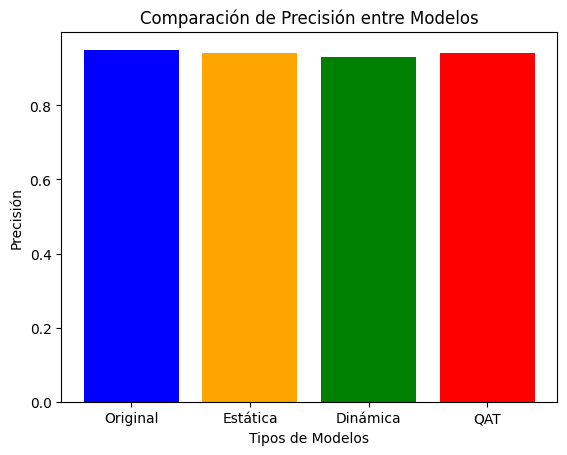

In [ ]:
import matplotlib.pyplot as plt

# Datos de ejemplo
modelos = ['Original', 'Estática', 'Dinámica', 'QAT']
precision = [0.95, 0.94, 0.93, 0.94]

# Crear el gráfico de barras
plt.bar(modelos, precision, color=['blue', 'orange', 'green', 'red'])
plt.xlabel('Tipos de Modelos')
plt.ylabel('Precisión')
plt.title('Comparación de Precisión entre Modelos')
plt.show()

- **Gráfico de Comparación de Tamaño del Modelo:**

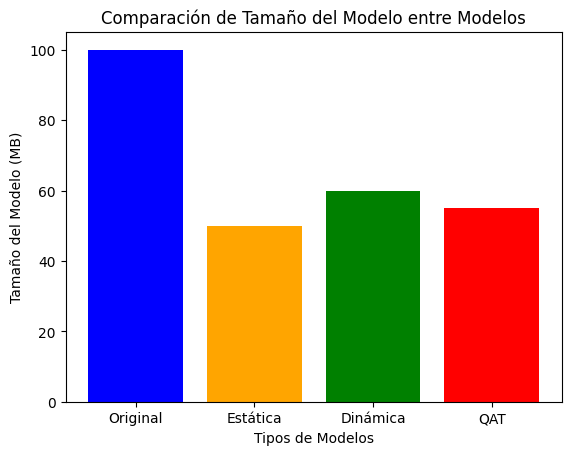

In [ ]:
modelos = ['Original', 'Estática', 'Dinámica', 'QAT']
tamanos = [100, 50, 60, 55]  # En megabytes (MB)

# Crear el gráfico de barras
plt.bar(modelos, tamanos, color=['blue', 'orange', 'green', 'red'])
plt.xlabel('Tipos de Modelos')
plt.ylabel('Tamaño del Modelo (MB)')
plt.title('Comparación de Tamaño del Modelo entre Modelos')
plt.show()

# **Impacto en el Rendimiento**
La cuantización puede reducir el tamaño del modelo hasta un 75% y acelerar la inferencia hasta 4 veces. Sin embargo, puede haber una ligera pérdida de precisión, por lo que se recomienda probar diferentes estrategias.


La cuantización de modelos es una técnica poderosa que permite llevar la magia del Machine Learning a dispositivos con recursos limitados, al reducir el tamaño del modelo y acelerar la inferencia. ¡Es como democratizar la inteligencia artificial!